# Imports and Functions

In [1]:
import math 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neighbors import KDTree
from sklearn.svm import SVC
%matplotlib notebook

global selection_model

import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 0 #0 for 0.5, 1 for isolated, 2 for random, 3 for best

global threshold_low
global threshold_high
threshold_low = -500
threshold_high = 0

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def xnew(x): 
    return (-512+(((x+5)*(512--512))/(51+5)))
def ynew(y): 
    return (-512+(((y+2)*(512--512))/(53+2)))

def eggholder(x):
       
    return (-(x[1]+47)*(math.sin(math.sqrt(abs((x[0]/2)+(x[1]+47))))))-((x[0])*(math.sin(math.sqrt(abs((x[0])+(x[1]+47))))))

def eggholderColor(x, threshold_low, threshold_high):
    
    if threshold_low < eggholder((xnew(x[0]),xnew(x[1]))) <threshold_high:
        return 1
    else:
        return 0

In [4]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global Zeggholder
    global xx,yy
    global Big_df
    global Big_df_land


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .5  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = SVC(probability=True, gamma = 0.01)
    clf.fit(X, y)
    
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    Zeggholder = []
    eggholdercoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(12320):
        Zeggholder.append(eggholderColor(eggholdercoords[i],threshold_low, threshold_high))



    Z_model_prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', Zeggholder)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(12320):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
#     print('isolated', testpoints[ifinal])
    return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[::5, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist()))
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()

    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


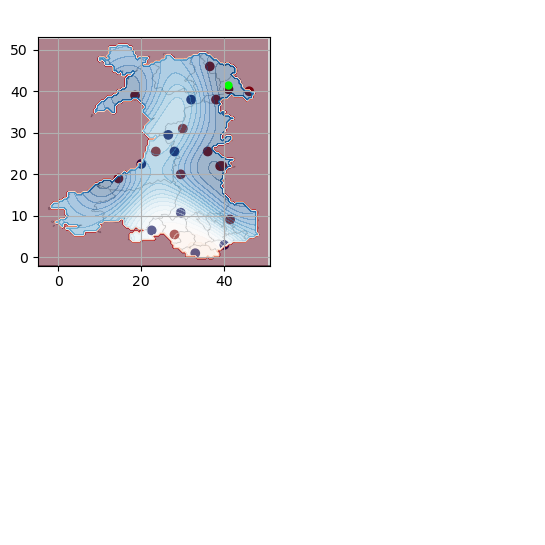

iteration  1
Accuracy is 0.52143818496443
iteration  2
Accuracy is 0.4895212459142473
iteration  3
Accuracy is 0.5027879253989618
iteration  4
Accuracy is 0.4906748702172659
iteration  5
Accuracy is 0.5052874447221688
iteration  6
Accuracy is 0.49182849452028454
iteration  7
Accuracy is 0.4576043068640646
iteration  8
Accuracy is 0.48009998077292826
iteration  9
Accuracy is 0.499134781772736
iteration  10
Accuracy is 0.4964429917323592
iteration  11
Accuracy is 0.4952893674293405
iteration  12
Accuracy is 0.502595654681792
iteration  13
Accuracy is 0.4810613343587772
iteration  14
Accuracy is 0.4810613343587772
iteration  15
Accuracy is 0.4810613343587772
iteration  16
Accuracy is 0.4747164006921746
iteration  17
Accuracy is 0.48125360507594694
iteration  18
Accuracy is 0.48125360507594694
iteration  19
Accuracy is 0.4964429917323592
iteration  20
Accuracy is 0.4924053066717939
iteration  21
Accuracy is 0.49778888675254757
experiment:  1


<IPython.core.display.Javascript object>


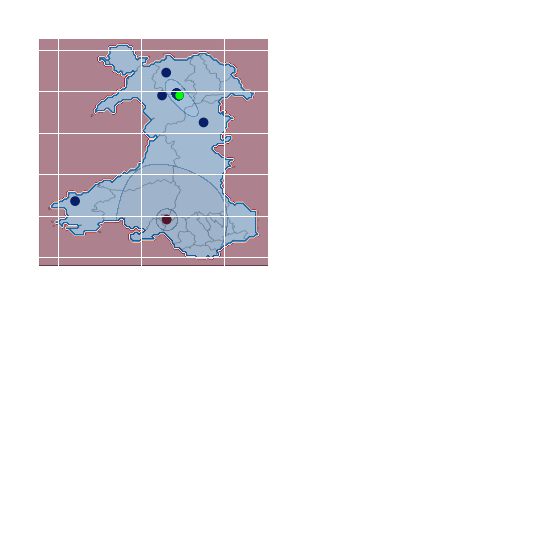

iteration  1
Accuracy is 0.5370121130551817
iteration  2
Accuracy is 0.5066333397423572
iteration  3
Accuracy is 0.5095174004999039
iteration  4
Accuracy is 0.5091328590655643
iteration  5
Accuracy is 0.5091328590655643
iteration  6
Accuracy is 0.5091328590655643
iteration  7
Accuracy is 0.5091328590655643
iteration  8
Accuracy is 0.5091328590655643
iteration  9
Accuracy is 0.5091328590655643
iteration  10
Accuracy is 0.5091328590655643
iteration  11
Accuracy is 0.5091328590655643
iteration  12
Accuracy is 0.5091328590655643
iteration  13
Accuracy is 0.5091328590655643
iteration  14
Accuracy is 0.5091328590655643
iteration  15
Accuracy is 0.5091328590655643
iteration  16
Accuracy is 0.5091328590655643
iteration  17
Accuracy is 0.5091328590655643
iteration  18
Accuracy is 0.5091328590655643
iteration  19
Accuracy is 0.5091328590655643
iteration  20
Accuracy is 0.5091328590655643
iteration  21
Accuracy is 0.5091328590655643
experiment:  2


<IPython.core.display.Javascript object>


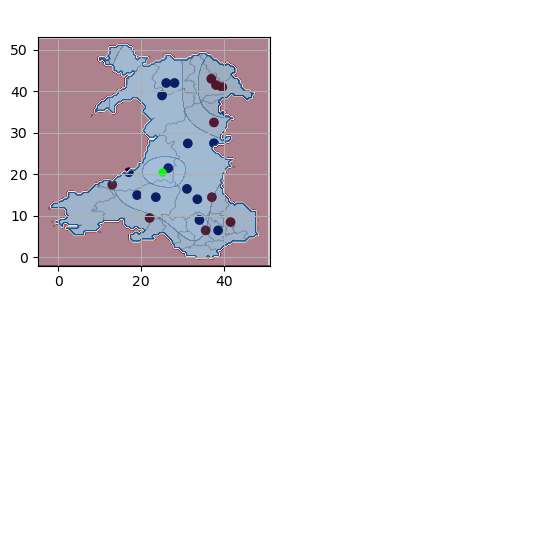

iteration  1
Accuracy is 0.485483560853682
iteration  2
Accuracy is 0.4899057873485868
iteration  3
Accuracy is 0.5366275716208422
iteration  4
Accuracy is 0.5366275716208422
iteration  5
Accuracy is 0.5314362622572583
iteration  6
Accuracy is 0.5056719861565083
iteration  7
Accuracy is 0.5199000192270717
iteration  8
Accuracy is 0.5472024610651798
iteration  9
Accuracy is 0.5425879638531051
iteration  10
Accuracy is 0.520476831378581
iteration  11
Accuracy is 0.5247067871563161
iteration  12
Accuracy is 0.5385502787925399
iteration  13
Accuracy is 0.5379734666410305
iteration  14
Accuracy is 0.5379734666410305
iteration  15
Accuracy is 0.5348971351663142
iteration  16
Accuracy is 0.5352816766006537
iteration  17
Accuracy is 0.5287444722168814
iteration  18
Accuracy is 0.5231686214189579
iteration  19
Accuracy is 0.5381657373582004
iteration  20
Accuracy is 0.5381657373582004
iteration  21
Accuracy is 0.5310517208229186
experiment:  3


<IPython.core.display.Javascript object>


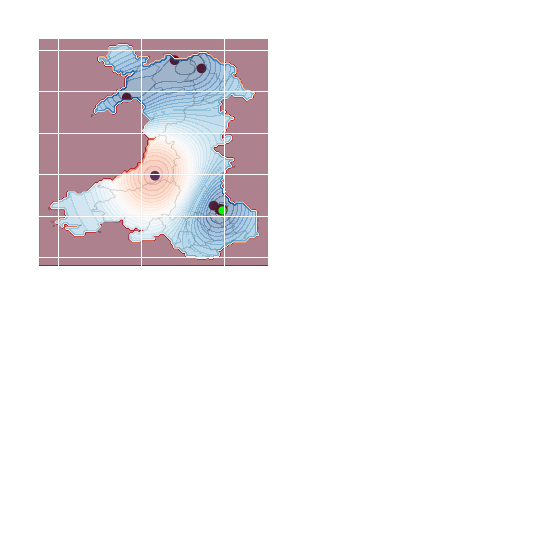

iteration  1
Accuracy is 0.5149009805806576
iteration  2
Accuracy is 0.5066333397423572
iteration  3
Accuracy is 0.5097096712170737
iteration  4
Accuracy is 0.5075946933282061
iteration  5
Accuracy is 0.5075946933282061
iteration  6
Accuracy is 0.5075946933282061
iteration  7
Accuracy is 0.5075946933282061
iteration  8
Accuracy is 0.5075946933282061
iteration  9
Accuracy is 0.5075946933282061
iteration  10
Accuracy is 0.5075946933282061
iteration  11
Accuracy is 0.5075946933282061
iteration  12
Accuracy is 0.5075946933282061
iteration  13
Accuracy is 0.5075946933282061
iteration  14
Accuracy is 0.5075946933282061
iteration  15
Accuracy is 0.5075946933282061
iteration  16
Accuracy is 0.5075946933282061
iteration  17
Accuracy is 0.5075946933282061
iteration  18
Accuracy is 0.5075946933282061
iteration  19
Accuracy is 0.5075946933282061
iteration  20
Accuracy is 0.5075946933282061
iteration  21
Accuracy is 0.5075946933282061
experiment:  4


<IPython.core.display.Javascript object>


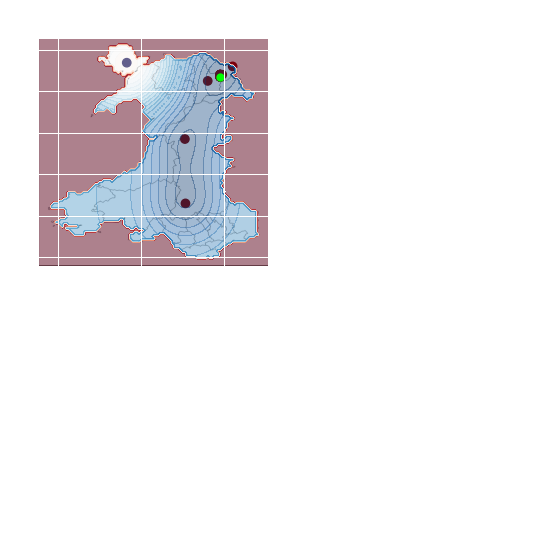

iteration  1
Accuracy is 0.49048259950009615
iteration  2
Accuracy is 0.522207267833109
iteration  3
Accuracy is 0.5237454335704672
iteration  4
Accuracy is 0.5231686214189579
iteration  5
Accuracy is 0.5231686214189579
iteration  6
Accuracy is 0.5231686214189579
iteration  7
Accuracy is 0.5231686214189579
iteration  8
Accuracy is 0.5231686214189579
iteration  9
Accuracy is 0.5231686214189579
iteration  10
Accuracy is 0.5231686214189579
iteration  11
Accuracy is 0.5231686214189579
iteration  12
Accuracy is 0.5231686214189579
iteration  13
Accuracy is 0.5231686214189579
iteration  14
Accuracy is 0.5231686214189579
iteration  15
Accuracy is 0.5231686214189579
iteration  16
Accuracy is 0.5231686214189579
iteration  17
Accuracy is 0.5231686214189579
iteration  18
Accuracy is 0.5231686214189579
iteration  19
Accuracy is 0.5231686214189579
iteration  20
Accuracy is 0.5231686214189579
iteration  21
Accuracy is 0.5231686214189579
experiment:  5


<IPython.core.display.Javascript object>


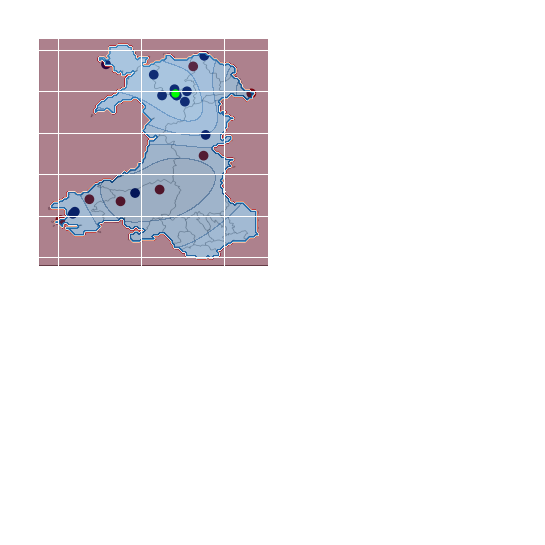

iteration  1
Accuracy is 0.47510094212651416
iteration  2
Accuracy is 0.5097096712170737
iteration  3
Accuracy is 0.4916362238031148
iteration  4
Accuracy is 0.5006729475100942
iteration  5
Accuracy is 0.506056527590848
iteration  6
Accuracy is 0.49567390886368007
iteration  7
Accuracy is 0.5033647375504711
iteration  8
Accuracy is 0.5081715054797155
iteration  9
Accuracy is 0.4975966160353778
iteration  10
Accuracy is 0.5143241684291482
iteration  11
Accuracy is 0.5135550855604691
iteration  12
Accuracy is 0.5120169198231109
iteration  13
Accuracy is 0.5120169198231109
iteration  14
Accuracy is 0.5120169198231109
iteration  15
Accuracy is 0.502595654681792
iteration  16
Accuracy is 0.517977312055374
iteration  17
Accuracy is 0.517977312055374
iteration  18
Accuracy is 0.5110555662372621
iteration  19
Accuracy is 0.5110555662372621
iteration  20
Accuracy is 0.5110555662372621
iteration  21
Accuracy is 0.5110555662372621
experiment:  6


<IPython.core.display.Javascript object>


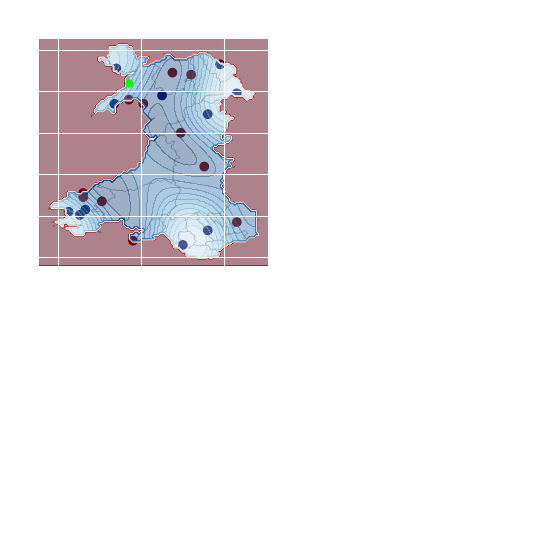

iteration  1
Accuracy is 0.5322053451259373
iteration  2
Accuracy is 0.49567390886368007
iteration  3
Accuracy is 0.5054797154393386
iteration  4
Accuracy is 0.5054797154393386
iteration  5
Accuracy is 0.5066333397423572
iteration  6
Accuracy is 0.49413574312632186
iteration  7
Accuracy is 0.4950970967121707
iteration  8
Accuracy is 0.5200922899442415
iteration  9
Accuracy is 0.4993270524899058
iteration  10
Accuracy is 0.4868294558738704
iteration  11
Accuracy is 0.49182849452028454
iteration  12
Accuracy is 0.4822149586617958
iteration  13
Accuracy is 0.508556046914055
iteration  14
Accuracy is 0.48971351663141705
iteration  15
Accuracy is 0.49586617958084983
iteration  16
Accuracy is 0.5018265718131129
iteration  17
Accuracy is 0.4968275331666987
iteration  18
Accuracy is 0.4845222072678331
iteration  19
Accuracy is 0.49971159392424536
iteration  20
Accuracy is 0.4899057873485868
iteration  21
Accuracy is 0.5033647375504711
experiment:  7


<IPython.core.display.Javascript object>


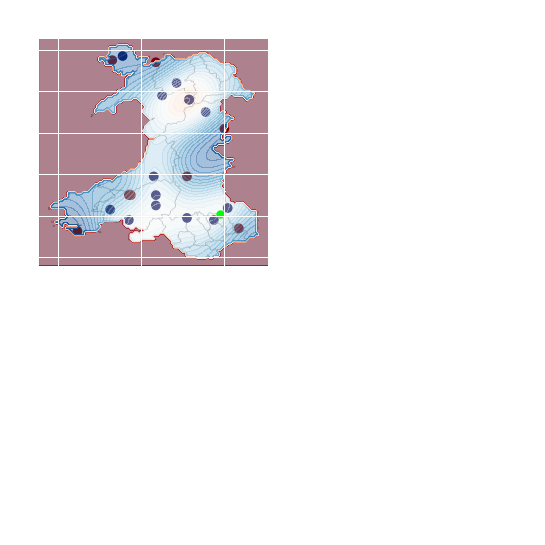

iteration  1
Accuracy is 0.46837146702557203
iteration  2
Accuracy is 0.48932897519707746
iteration  3
Accuracy is 0.485483560853682
iteration  4
Accuracy is 0.4950970967121707
iteration  5
Accuracy is 0.47337050567198613
iteration  6
Accuracy is 0.45414343395500867
iteration  7
Accuracy is 0.4802922514900981
iteration  8
Accuracy is 0.48413766583349355
iteration  9
Accuracy is 0.4714477985002884
iteration  10
Accuracy is 0.4729859642376466
iteration  11
Accuracy is 0.464141511247837
iteration  12
Accuracy is 0.47125552778311863
iteration  13
Accuracy is 0.5033647375504711
iteration  14
Accuracy is 0.5037492789848106
iteration  15
Accuracy is 0.5037492789848106
iteration  16
Accuracy is 0.5037492789848106
iteration  17
Accuracy is 0.5002884060757546
iteration  18
Accuracy is 0.4987502403383965
iteration  19
Accuracy is 0.4843299365506633
iteration  20
Accuracy is 0.49259757738896365
iteration  21
Accuracy is 0.4927898481061334
experiment:  8


<IPython.core.display.Javascript object>


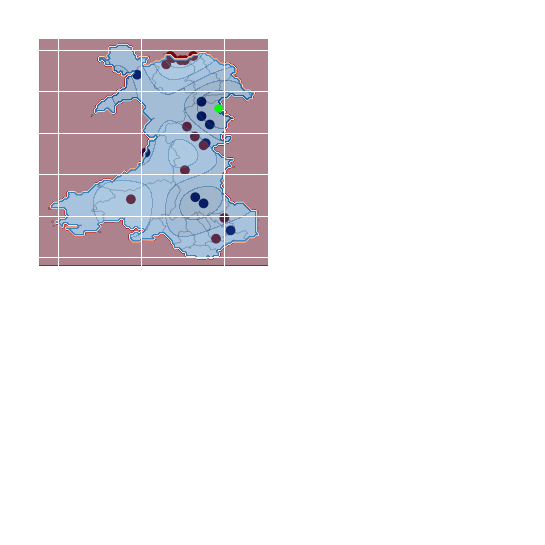

iteration  1
Accuracy is 0.5273985771966929
iteration  2
Accuracy is 0.500865218227264
iteration  3
Accuracy is 0.5024033839646221
iteration  4
Accuracy is 0.5054797154393386
iteration  5
Accuracy is 0.5072101518938665
iteration  6
Accuracy is 0.4943280138434916
iteration  7
Accuracy is 0.5172082291866948
iteration  8
Accuracy is 0.5168236877523553
iteration  9
Accuracy is 0.5150932512978273
iteration  10
Accuracy is 0.5252835993078254
iteration  11
Accuracy is 0.5223995385502788
iteration  12
Accuracy is 0.5235531628532974
iteration  13
Accuracy is 0.4950970967121707
iteration  14
Accuracy is 0.4950970967121707
iteration  15
Accuracy is 0.4950970967121707
iteration  16
Accuracy is 0.4968275331666987
iteration  17
Accuracy is 0.49586617958084983
iteration  18
Accuracy is 0.49663526244952894
iteration  19
Accuracy is 0.5047106325706595
iteration  20
Accuracy is 0.5047106325706595
iteration  21
Accuracy is 0.5045183618534897
experiment:  9


<IPython.core.display.Javascript object>


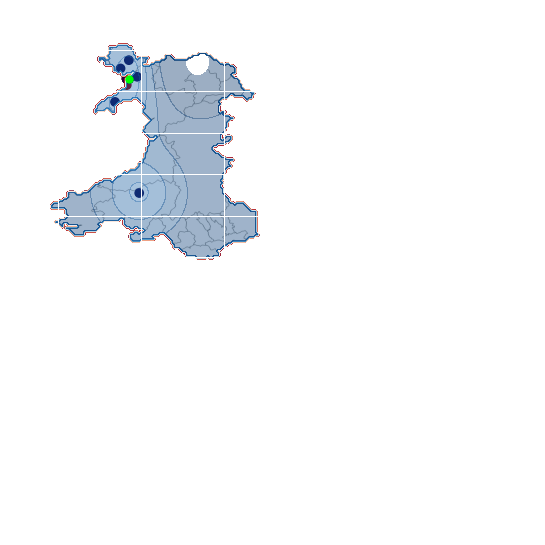

iteration  1
Accuracy is 0.5279753893482023
iteration  2
Accuracy is 0.5383580080753702
iteration  3
Accuracy is 0.5377811959238608
iteration  4
Accuracy is 0.5377811959238608
iteration  5
Accuracy is 0.5298980965199
iteration  6
Accuracy is 0.5287444722168814
iteration  7
Accuracy is 0.5287444722168814
iteration  8
Accuracy is 0.5287444722168814
iteration  9
Accuracy is 0.5287444722168814
iteration  10
Accuracy is 0.5287444722168814
iteration  11
Accuracy is 0.5287444722168814
iteration  12
Accuracy is 0.5287444722168814
iteration  13
Accuracy is 0.5287444722168814
iteration  14
Accuracy is 0.5287444722168814
iteration  15
Accuracy is 0.5287444722168814
iteration  16
Accuracy is 0.5287444722168814
iteration  17
Accuracy is 0.5287444722168814
iteration  18
Accuracy is 0.5287444722168814
iteration  19
Accuracy is 0.5287444722168814
iteration  20
Accuracy is 0.5287444722168814
iteration  21
Accuracy is 0.5287444722168814
experiment:  10


<IPython.core.display.Javascript object>


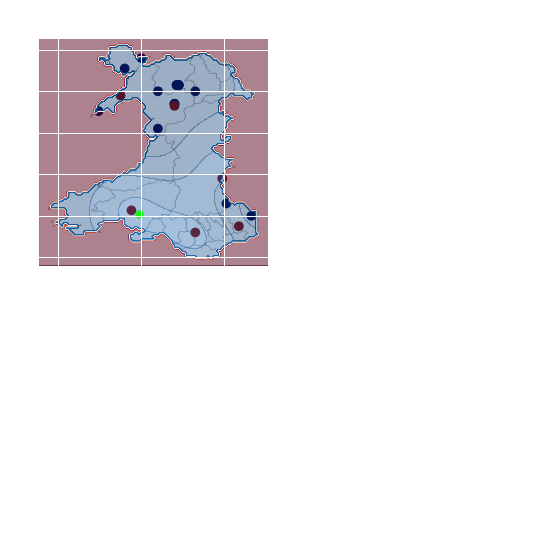

iteration  1
Accuracy is 0.4843299365506633
iteration  2
Accuracy is 0.4866371851567006
iteration  3
Accuracy is 0.4839453951163238
iteration  4
Accuracy is 0.5039415497019804
iteration  5
Accuracy is 0.5298980965199
iteration  6
Accuracy is 0.49951932320707554
iteration  7
Accuracy is 0.5081715054797155
iteration  8
Accuracy is 0.4983656989040569
iteration  9
Accuracy is 0.5012497596616036
iteration  10
Accuracy is 0.5062487983080177
iteration  11
Accuracy is 0.5052874447221688
iteration  12
Accuracy is 0.5072101518938665
iteration  13
Accuracy is 0.5072101518938665
iteration  14
Accuracy is 0.5072101518938665
iteration  15
Accuracy is 0.5079792347625457
iteration  16
Accuracy is 0.5079792347625457
iteration  17
Accuracy is 0.5079792347625457
iteration  18
Accuracy is 0.5079792347625457
iteration  19
Accuracy is 0.5079792347625457
iteration  20
Accuracy is 0.5079792347625457
iteration  21
Accuracy is 0.5079792347625457
experiment:  11


<IPython.core.display.Javascript object>


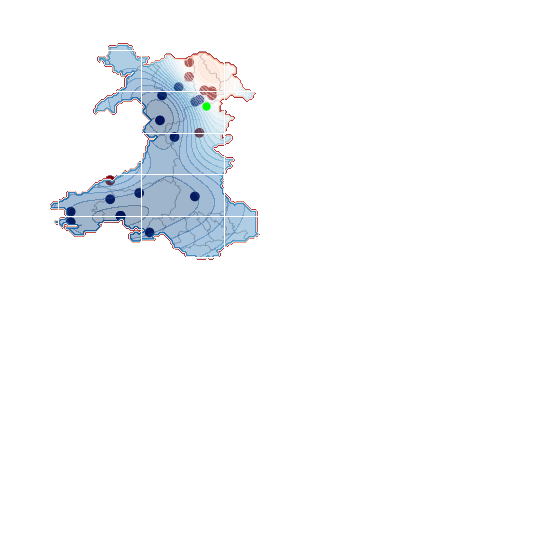

iteration  1
Accuracy is 0.5097096712170737
iteration  2
Accuracy is 0.5116323783887714
iteration  3
Accuracy is 0.5083637761968852
iteration  4
Accuracy is 0.5137473562776389
iteration  5
Accuracy is 0.5079792347625457
iteration  6
Accuracy is 0.5075946933282061
iteration  7
Accuracy is 0.506825610459527
iteration  8
Accuracy is 0.506825610459527
iteration  9
Accuracy is 0.506825610459527
iteration  10
Accuracy is 0.506825610459527
iteration  11
Accuracy is 0.5314362622572583
iteration  12
Accuracy is 0.5248990578734859
iteration  13
Accuracy is 0.5322053451259373
iteration  14
Accuracy is 0.5422034224187656
iteration  15
Accuracy is 0.5264372236108441
iteration  16
Accuracy is 0.5275908479138627
iteration  17
Accuracy is 0.545279753893482
iteration  18
Accuracy is 0.545279753893482
iteration  19
Accuracy is 0.5400884445298981
iteration  20
Accuracy is 0.5646990963276293
iteration  21
Accuracy is 0.5497019803883868
experiment:  12


<IPython.core.display.Javascript object>


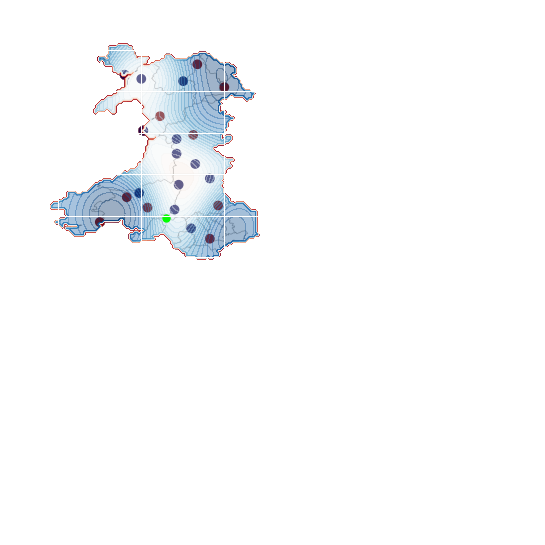

iteration  1
Accuracy is 0.47164006921745816
iteration  2
Accuracy is 0.4935589309748125
iteration  3
Accuracy is 0.49125168236877526
iteration  4
Accuracy is 0.50432609113632
iteration  5
Accuracy is 0.4899057873485868
iteration  6
Accuracy is 0.4860603730051913
iteration  7
Accuracy is 0.45510478754085754
iteration  8
Accuracy is 0.4758700249951932
iteration  9
Accuracy is 0.483753124399154
iteration  10
Accuracy is 0.5045183618534897
iteration  11
Accuracy is 0.5131705441261296
iteration  12
Accuracy is 0.5002884060757546
iteration  13
Accuracy is 0.5143241684291482
iteration  14
Accuracy is 0.5166314170351856
iteration  15
Accuracy is 0.5212459142472602
iteration  16
Accuracy is 0.5235531628532974
iteration  17
Accuracy is 0.5145164391463181
iteration  18
Accuracy is 0.5058642568736781
iteration  19
Accuracy is 0.5006729475100942
iteration  20
Accuracy is 0.5058642568736781
iteration  21
Accuracy is 0.5058642568736781
experiment:  13


<IPython.core.display.Javascript object>


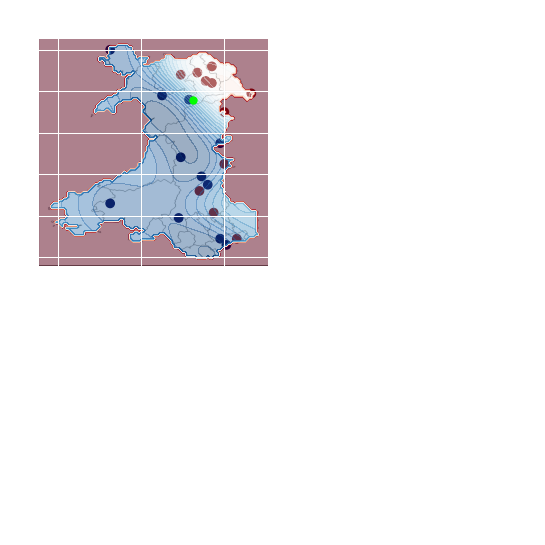

iteration  1
Accuracy is 0.5020188425302826
iteration  2
Accuracy is 0.4870217265910402
iteration  3
Accuracy is 0.4866371851567006
iteration  4
Accuracy is 0.5045183618534897
iteration  5
Accuracy is 0.5635454720246107
iteration  6
Accuracy is 0.5062487983080177
iteration  7
Accuracy is 0.5099019419342434
iteration  8
Accuracy is 0.5141318977119784
iteration  9
Accuracy is 0.5074024226110363
iteration  10
Accuracy is 0.5074024226110363
iteration  11
Accuracy is 0.5150932512978273
iteration  12
Accuracy is 0.5329744279946165
iteration  13
Accuracy is 0.5462411074793309
iteration  14
Accuracy is 0.5345125937319746
iteration  15
Accuracy is 0.5473947317823495
iteration  16
Accuracy is 0.5550855604691406
iteration  17
Accuracy is 0.522207267833109
iteration  18
Accuracy is 0.5045183618534897
iteration  19
Accuracy is 0.5285522014997116
iteration  20
Accuracy is 0.5610459527014036
iteration  21
Accuracy is 0.5600845991155547
experiment:  14


<IPython.core.display.Javascript object>


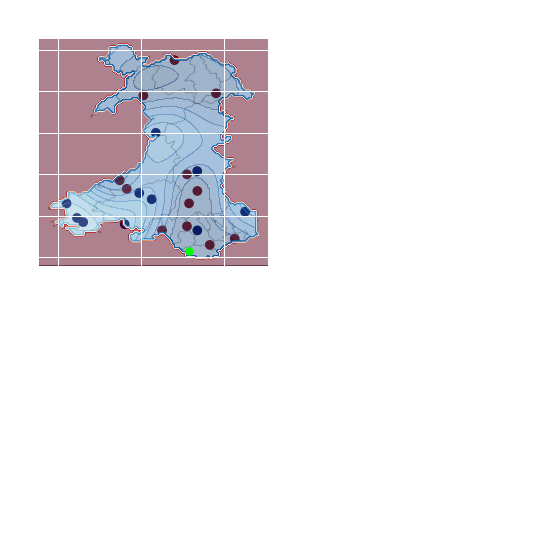

iteration  1
Accuracy is 0.46260334551047877
iteration  2
Accuracy is 0.4987502403383965
iteration  3
Accuracy is 0.500865218227264
iteration  4
Accuracy is 0.5056719861565083
iteration  5
Accuracy is 0.5124014612574505
iteration  6
Accuracy is 0.5135550855604691
iteration  7
Accuracy is 0.5125937319746202
iteration  8
Accuracy is 0.5097096712170737
iteration  9
Accuracy is 0.5106710248029225
iteration  10
Accuracy is 0.5087483176312247
iteration  11
Accuracy is 0.5072101518938665
iteration  12
Accuracy is 0.5062487983080177
iteration  13
Accuracy is 0.5129782734089599
iteration  14
Accuracy is 0.5216304556815997
iteration  15
Accuracy is 0.5248990578734859
iteration  16
Accuracy is 0.5408575273985772
iteration  17
Accuracy is 0.5191309363583926
iteration  18
Accuracy is 0.5397039030955586
iteration  19
Accuracy is 0.5202845606614113
iteration  20
Accuracy is 0.5202845606614113
iteration  21
Accuracy is 0.5202845606614113
experiment:  15


<IPython.core.display.Javascript object>


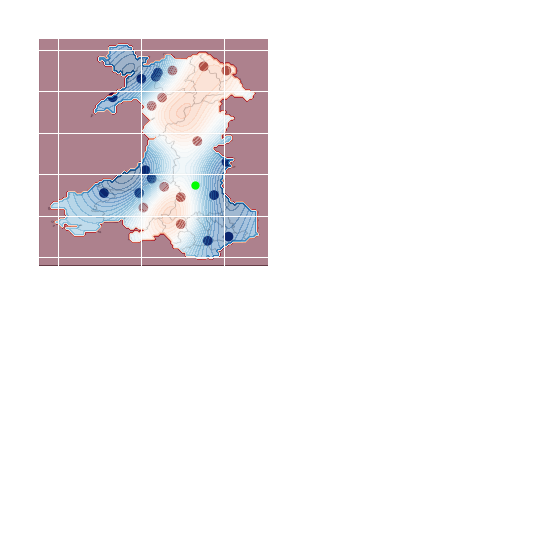

iteration  1
Accuracy is 0.4935589309748125
iteration  2
Accuracy is 0.5018265718131129
iteration  3
Accuracy is 0.5254758700249952
iteration  4
Accuracy is 0.5118246491059412
iteration  5
Accuracy is 0.5325898865602768
iteration  6
Accuracy is 0.5439338588732936
iteration  7
Accuracy is 0.5318208036915978
iteration  8
Accuracy is 0.537588925206691
iteration  9
Accuracy is 0.5306671793885791
iteration  10
Accuracy is 0.5131705441261296
iteration  11
Accuracy is 0.5314362622572583
iteration  12
Accuracy is 0.5343203230148048
iteration  13
Accuracy is 0.5343203230148048
iteration  14
Accuracy is 0.5329744279946165
iteration  15
Accuracy is 0.5331666987117862
iteration  16
Accuracy is 0.5362430301865025
iteration  17
Accuracy is 0.5395116323783887
iteration  18
Accuracy is 0.5458565660449913
iteration  19
Accuracy is 0.5395116323783887
iteration  20
Accuracy is 0.5398961738127284
iteration  21
Accuracy is 0.5398961738127284
experiment:  16


<IPython.core.display.Javascript object>


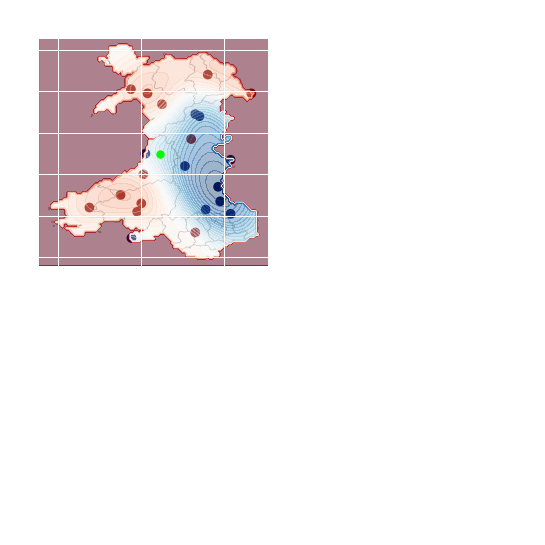

iteration  1
Accuracy is 0.5145164391463181
iteration  2
Accuracy is 0.47567775427802345
iteration  3
Accuracy is 0.49490482599500096
iteration  4
Accuracy is 0.46241107479330895
iteration  5
Accuracy is 0.4776004614497212
iteration  6
Accuracy is 0.4829840415304749
iteration  7
Accuracy is 0.5124014612574505
iteration  8
Accuracy is 0.5095174004999039
iteration  9
Accuracy is 0.5029801961161315
iteration  10
Accuracy is 0.5120169198231109
iteration  11
Accuracy is 0.4964429917323592
iteration  12
Accuracy is 0.4979811574697174
iteration  13
Accuracy is 0.5012497596616036
iteration  14
Accuracy is 0.5037492789848106
iteration  15
Accuracy is 0.5037492789848106
iteration  16
Accuracy is 0.5079792347625457
iteration  17
Accuracy is 0.5079792347625457
iteration  18
Accuracy is 0.5079792347625457
iteration  19
Accuracy is 0.49567390886368007
iteration  20
Accuracy is 0.5164391463180158
iteration  21
Accuracy is 0.5108632955200922
experiment:  17


<IPython.core.display.Javascript object>


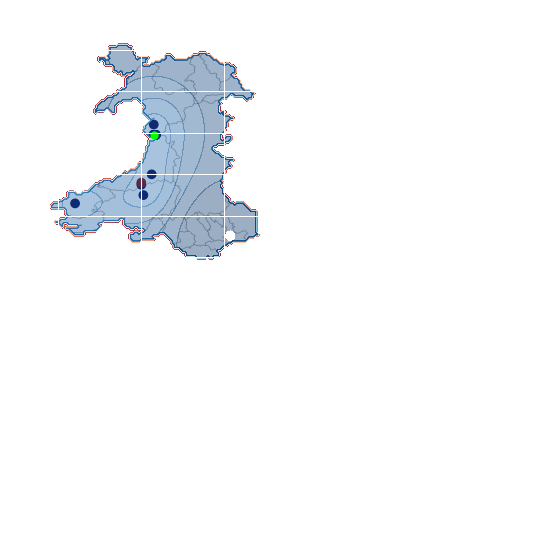

iteration  1
Accuracy is 0.5483560853681985
iteration  2
Accuracy is 0.5091328590655643
iteration  3
Accuracy is 0.5083637761968852
iteration  4
Accuracy is 0.5083637761968852
iteration  5
Accuracy is 0.5083637761968852
iteration  6
Accuracy is 0.5079792347625457
iteration  7
Accuracy is 0.5079792347625457
iteration  8
Accuracy is 0.5079792347625457
iteration  9
Accuracy is 0.5079792347625457
iteration  10
Accuracy is 0.5079792347625457
iteration  11
Accuracy is 0.5079792347625457
iteration  12
Accuracy is 0.5079792347625457
iteration  13
Accuracy is 0.5079792347625457
iteration  14
Accuracy is 0.5079792347625457
iteration  15
Accuracy is 0.5079792347625457
iteration  16
Accuracy is 0.5079792347625457
iteration  17
Accuracy is 0.5079792347625457
iteration  18
Accuracy is 0.5079792347625457
iteration  19
Accuracy is 0.5079792347625457
iteration  20
Accuracy is 0.5079792347625457
iteration  21
Accuracy is 0.5079792347625457
experiment:  18


<IPython.core.display.Javascript object>


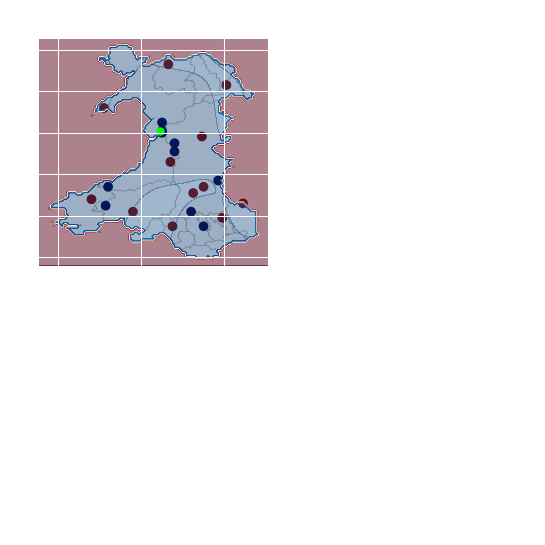

iteration  1
Accuracy is 0.5137473562776389
iteration  2
Accuracy is 0.4962507210151894
iteration  3
Accuracy is 0.5024033839646221
iteration  4
Accuracy is 0.5343203230148048
iteration  5
Accuracy is 0.533358969428956
iteration  6
Accuracy is 0.5116323783887714
iteration  7
Accuracy is 0.4770236492982119
iteration  8
Accuracy is 0.506825610459527
iteration  9
Accuracy is 0.47683137858104213
iteration  10
Accuracy is 0.4972120746010383
iteration  11
Accuracy is 0.49125168236877526
iteration  12
Accuracy is 0.4962507210151894
iteration  13
Accuracy is 0.49894251105556625
iteration  14
Accuracy is 0.49894251105556625
iteration  15
Accuracy is 0.4860603730051913
iteration  16
Accuracy is 0.48567583157085176
iteration  17
Accuracy is 0.4866371851567006
iteration  18
Accuracy is 0.4866371851567006
iteration  19
Accuracy is 0.500865218227264
iteration  20
Accuracy is 0.4979811574697174
iteration  21
Accuracy is 0.48125360507594694
experiment:  19


<IPython.core.display.Javascript object>


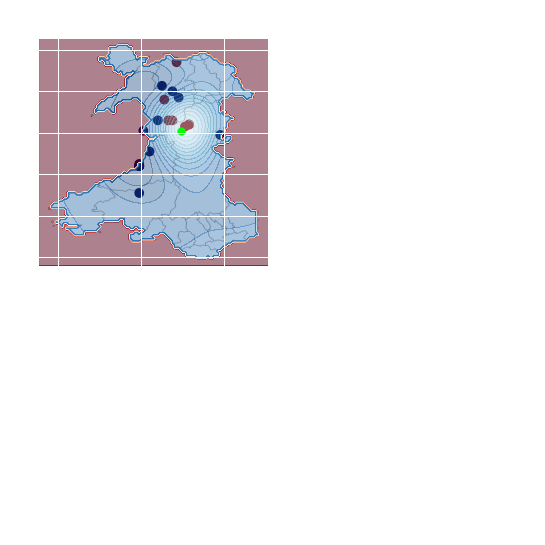

iteration  1
Accuracy is 0.48932897519707746
iteration  2
Accuracy is 0.49855796962122667
iteration  3
Accuracy is 0.4968275331666987
iteration  4
Accuracy is 0.5170159584695251
iteration  5
Accuracy is 0.49855796962122667
iteration  6
Accuracy is 0.49855796962122667
iteration  7
Accuracy is 0.49855796962122667
iteration  8
Accuracy is 0.49855796962122667
iteration  9
Accuracy is 0.49855796962122667
iteration  10
Accuracy is 0.49855796962122667
iteration  11
Accuracy is 0.49855796962122667
iteration  12
Accuracy is 0.49855796962122667
iteration  13
Accuracy is 0.49855796962122667
iteration  14
Accuracy is 0.5147087098634878
iteration  15
Accuracy is 0.5147087098634878
iteration  16
Accuracy is 0.5241299750048067
iteration  17
Accuracy is 0.5241299750048067
iteration  18
Accuracy is 0.48336858296481444
iteration  19
Accuracy is 0.4943280138434916
iteration  20
Accuracy is 0.4776004614497212
iteration  21
Accuracy is 0.48336858296481444
experiment:  20


<IPython.core.display.Javascript object>


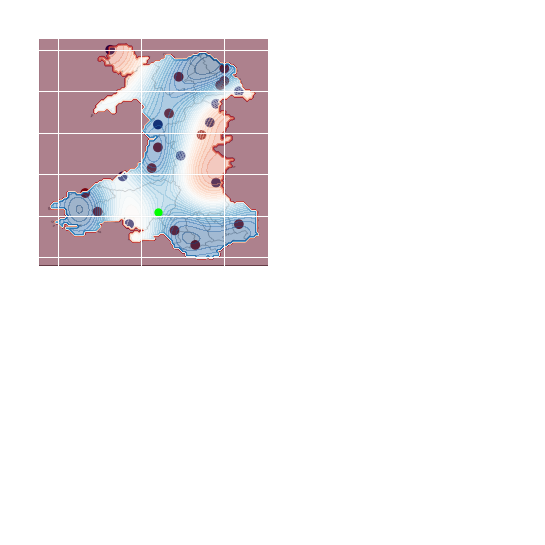

iteration  1
Accuracy is 0.5127860026917901
iteration  2
Accuracy is 0.48279177081330515
iteration  3
Accuracy is 0.4999038646414151
iteration  4
Accuracy is 0.47164006921745816
iteration  5
Accuracy is 0.5097096712170737
iteration  6
Accuracy is 0.5152855220149971
iteration  7
Accuracy is 0.493174389540473
iteration  8
Accuracy is 0.5166314170351856
iteration  9
Accuracy is 0.5024033839646221
iteration  10
Accuracy is 0.5143241684291482
iteration  11
Accuracy is 0.5462411074793309
iteration  12
Accuracy is 0.5329744279946165
iteration  13
Accuracy is 0.5095174004999039
iteration  14
Accuracy is 0.5187463949240531
iteration  15
Accuracy is 0.5156700634493366
iteration  16
Accuracy is 0.5175927706210344
iteration  17
Accuracy is 0.5183618534897135
iteration  18
Accuracy is 0.5187463949240531
iteration  19
Accuracy is 0.5131705441261296
iteration  20
Accuracy is 0.5135550855604691
iteration  21
Accuracy is 0.5120169198231109


In [7]:
from random import randint
import time

valid_seeds = [12,15,17,21,23,24,25,31,35,36,37,41,43,45,49,52,55,56,57,58,59]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            eggholderColor(landpoints[value],threshold_low, threshold_high)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic', s = 3)
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], eggholderColor(nextpoint,threshold_low, threshold_high)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [8]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 54.62 %
Improvement is = 3.35 %


In [9]:
Results

[[0.52143818496443,
  0.4895212459142473,
  0.5027879253989618,
  0.4906748702172659,
  0.5052874447221688,
  0.49182849452028454,
  0.4576043068640646,
  0.48009998077292826,
  0.499134781772736,
  0.4964429917323592,
  0.4952893674293405,
  0.502595654681792,
  0.4810613343587772,
  0.4810613343587772,
  0.4810613343587772,
  0.4747164006921746,
  0.48125360507594694,
  0.48125360507594694,
  0.4964429917323592,
  0.4924053066717939,
  0.49778888675254757],
 [0.5370121130551817,
  0.5066333397423572,
  0.5095174004999039,
  0.5091328590655643,
  0.5091328590655643,
  0.5091328590655643,
  0.5091328590655643,
  0.5091328590655643,
  0.5091328590655643,
  0.5091328590655643,
  0.5091328590655643,
  0.5091328590655643,
  0.5091328590655643,
  0.5091328590655643,
  0.5091328590655643,
  0.5091328590655643,
  0.5091328590655643,
  0.5091328590655643,
  0.5091328590655643,
  0.5091328590655643,
  0.5091328590655643],
 [0.485483560853682,
  0.4899057873485868,
  0.5366275716208422,
  0.5366

In [11]:
np.savetxt('eggholder05rbf', Results)